## Feature Extraction for IBM Stock Price

Deep Learning

In [1]:
#importing libraries
import pandas as pd
import numpy as np
from numpy import arctan, isnan, nan, zeros_like
import pandas_ta as ta

#Import yahoo finance library
import yfinance as yf

#Import cufflinks for visualisation
import cufflinks as cf
cf.set_config_file(offline=True)

#Visualisation
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize']=(20,10)
plt.style.use('fivethirtyeight')
import seaborn as sns

import missingno as msno

#Ignore Warnings
import warnings
warnings.filterwarnings('ignore')


In [2]:
#NB drop - open, close, closing price!!


# imports
import os, random
import pandas as pd
import numpy as np
import datetime as dt
import pandas_ta as ta
from pathlib import Path

#import boruta
from boruta import BorutaPy

#warnings
import warnings
warnings.filterwarnings('ignore')

#plotting & oupus
from pprint import pprint
import matplotlib.pyplot as plt
plt.style.use('seaborn')

#functions from helper

#sklearn imports
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

#metrics
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import plot_confusion_matrix, auc, roc_curve, plot_roc_curve

#import classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier
from sklearn.neighbors import KNeighborsClassifier

pd.set_option('display.max_columns', 30)
pd.set_option('display.max_rows', 1000)

Import more than 20 years of data from Yahoo! Finance for stock IBM 

In [3]:
#Fetching stock data by specifying dates
df=yf.download('IBM',start='2000-01-01', end='2022-06-30',progress=True)#

#Checking first five rows
df.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1999-12-31,104.385757,104.684509,101.935944,103.130974,61.039993,3002334
2000-01-03,107.492828,110.898659,106.955070,110.898659,65.637459,10823694
2000-01-04,108.986618,109.464630,105.999046,107.134323,63.409454,8606279
2000-01-05,107.970840,114.483749,107.194077,110.898659,65.637459,13318927
2000-01-06,112.810707,113.706978,108.508606,108.986618,64.505775,8338607


In [4]:
df.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2022-06-23,137.139999,138.619995,136.500000,138.440002,138.440002,4547900
2022-06-24,139.199997,142.369995,139.130005,142.059998,142.059998,11493000
2022-06-27,142.259995,143.830002,141.949997,142.800003,142.800003,3936000
2022-06-28,142.919998,144.160004,141.320007,141.860001,141.860001,4064800
2022-06-29,142.740005,143.520004,139.500000,140.710007,140.710007,4161500


Define our Features

In [5]:
#Calculating Log Returns using numpy log function 
df['Daily_Return']=np.log(df).diff()['Adj Close'].dropna()
df['Return_1d']=df['Daily_Return'].shift(1)    
df['Return_2d']=df['Daily_Return'].shift(2)
df['Return_5d']=df['Daily_Return'].shift(5)
df['Ret_1M']=df['Daily_Return'].rolling(20).sum()

df['O-C']=df['Open']-df['Close']
df['H-L']=df['High']-df['Low']

#Momentum Factors
df['Momentum_1d']=df['Adj Close']-df['Adj Close'].shift(1)
df['Momentum_2d']=df['Adj Close']-df['Adj Close'].shift(2)
df['Momentum_5d']=df['Adj Close']-df['Adj Close'].shift(5)
df['Momentum_10d']=df['Adj Close']-df['Adj Close'].shift(10)
df['Momentum_21d']=df['Adj Close']-df['Adj Close'].shift(21)

#Simple Moving Average Factors
df['SMA_5d'] = df['Adj Close'].rolling(5).mean()
df['SMA_10d'] = df['Adj Close'].rolling(10).mean()
df['SMA_21d'] = df['Adj Close'].rolling(21).mean()
df['SMA_50d'] = df['Adj Close'].rolling(50).mean()
df['SMA_100d'] = df['Adj Close'].rolling(100).mean()
df['SMA_200d'] = df['Adj Close'].rolling(200).mean()

#EWMA Factors
n_obs=len(df)
alpha_EWM=2/(n_obs+1)

df['EMA']=df['Adj Close'].ewm(alpha=alpha_EWM).mean()
df['EMA_5d']=df['Adj Close'].ewm(5,adjust=False).mean()
df['EMA_10d']=df['Adj Close'].ewm(10,adjust=False).mean()
df['EMA_21d']=df['Adj Close'].ewm(21,adjust=False).mean()
df['EMA_50d']=df['Adj Close'].ewm(50,adjust=False).mean()
df['EMA_100d']=df['Adj Close'].ewm(100,adjust=False).mean()
df['EMA_200d']=df['Adj Close'].ewm(200,adjust=False).mean()

#Sign
df['Sign']=np.sign(df['Daily_Return'])
df['Sign M_1d']=np.sign(df['Momentum_1d']) 
df['Sign M_2d']=np.sign(df['Momentum_2d'])
df['Sign M_5d']=np.sign(df['Momentum_5d'])
df['Sign M_10d']=np.sign(df['Momentum_10d'])
df['Sign M_21d']=np.sign(df['Momentum_21d'])

#Volatility (different rolling periods)
df['SD_252Day'] = df['Adj Close'].rolling(252).std().shift()
df['SD_50Day'] = df['Adj Close'].rolling(50).std().shift()
df['SD_100Day'] = df['Adj Close'].rolling(100).std().shift()



Important Features


In [6]:
# 1
df['OBV'] = np.where(df['Adj Close'] < df['Adj Close'].shift(1), -df['Volume'], df['Volume']).cumsum()

In [7]:
# 2
typical_price = (df['High'] + df['Low'] + df['Adj Close']) / 3.0
window = 14
fillna = False
up_down = np.where(
    typical_price > typical_price.shift(1),
    1,
    np.where(typical_price < typical_price.shift(1), -1, 0),
)
mfr = typical_price * df['Volume'] * up_down

# Positive and negative money flow with n periods
min_periods = 0 if fillna else window
n_positive_mf = mfr.rolling(window, min_periods=min_periods).apply(
    lambda x: np.sum(np.where(x >= 0.0, x, 0.0)), raw=True
)
n_negative_mf = abs(
    mfr.rolling(window, min_periods=min_periods).apply(
        lambda x: np.sum(np.where(x < 0.0, x, 0.0)), raw=True
    )
)

# Money flow index
mfi = n_positive_mf / n_negative_mf
mfi = 100 - (100 / (1 + mfi))
df['mfi'] = mfi

In [8]:
# 3
mfv = ((df['Adj Close'] - df['Low']) - (df['High'] - df['Adj Close'])) / (
            df['High'] -df['Low'])

window = 20
fillna = False

mfv = mfv.fillna(0.0)  # float division by zero
mfv *= df['Volume']
min_periods = 0 if fillna else window
cmf = (
    mfv.rolling(window, min_periods=min_periods).sum()
    /  df['Volume'].rolling(window, min_periods=min_periods).sum()
)

df['chaikin'] = cmf

In [9]:
# 4
window = 25
fillna = False
min_periods = 0 if fillna else window
rolling_close = df['Adj Close'].rolling(
    window, min_periods=min_periods)

aroon_up = rolling_close.apply(
    lambda x: float(np.argmax(x) + 1) / window * 100, raw=True
)
aroon_down = rolling_close.apply(
    lambda x: float(np.argmin(x) + 1) / window * 100, raw=True
)
aroon_diff = aroon_up - aroon_down
df['aroon'] = aroon_diff

In [10]:
#Commodity Channel Index (CCI)
    #Determine the price level now relative to an average price level of a period of time
# 5

def mad(x): 
    return np.mean(np.abs(x - np.mean(x)))
window = 20
fillna = False
constant = 0.015
min_periods = 0 if fillna else window
typical_price = (df['High'] + df['Low'] + df['Adj Close']) / 3.0
cci = (
    typical_price
    - typical_price.rolling(window,min_periods=min_periods).mean()
) / (
    constant
    * typical_price.rolling(window, min_periods=min_periods).apply(
        mad, True
    )
)
df['CCI'] = cci

In [11]:
# 6

#Kaufman Adpative Moving Average (DEMA)
    #Moving average designed to be responsive to market trends and volatility

close_values = df['Adj Close'].values
vol = pd.Series(abs(df['Adj Close'] - np.roll(df['Adj Close'], 1)))
window = 10
fillna = False
min_periods = 0 if fillna else window
er_num = abs(close_values - np.roll(close_values, window))
er_den = vol.rolling(window, min_periods=min_periods).sum()
efficiency_ratio = er_num / er_den
pow1 = 2
pow2 = 30
smoothing_constant = (
    (efficiency_ratio * (2.0 / (pow1 + 1) - 2.0 / (pow2 + 1.0)) + 2 / (pow2 + 1.0))** 2.0).values

kama = np.zeros(smoothing_constant.size)
len_kama = len(kama)
first_value = True

for i in range(len_kama):
    if np.isnan(smoothing_constant[i]):
        kama[i] = np.nan
    elif first_value:
        kama[i] = close_values[i]
        first_value = False
    else:
        kama[i] = kama[i - 1] + smoothing_constant[i] * (close_values[i] - kama[i - 1])
        
df['kama'] = kama

In [12]:
# 7

#Relative Strength Index (RSI)
    #Deermines the strength of current price in relation to preceeding price
    
diff = df['Adj Close'].diff(1)
up_direction = diff.where(diff > 0, 0.0)
down_direction = -diff.where(diff < 0, 0.0)

window = 14
fillna = False

min_periods = 0 if fillna else window
emaup = up_direction.ewm(
    alpha=1 / window, min_periods=min_periods, adjust=False
).mean()
emadn = down_direction.ewm(
    alpha=1 / window, min_periods=min_periods, adjust=False
).mean()
relative_strength = emaup / emadn
rsi = pd.Series(
    np.where(emadn == 0, 100, 100 - (100 / (1 + relative_strength))),
    index=df['Adj Close'].index,
)
df['RSI'] = rsi

In [13]:
#Ultimate Oscillator (ULTOSC)
    #Estimates the price momentum of a security asset across different time frames
# 8
window1  = 7
window2  = 14
window3  = 28
weight1  = 4.0
weight2  = 2.0
weight3  = 1.0
fillna = False
            
def true_range(high: pd.Series, low: pd.Series, prev_close: pd.Series) -> pd.Series:
    tr1 = high - low
    tr2 = (high - prev_close).abs()
    tr3 = (low - prev_close).abs()
    true_range = pd.DataFrame(data={"tr1": tr1, "tr2": tr2, "tr3": tr3}).max(axis=1)
    return true_range
    
close_shift = df['Adj Close'].shift(1)
true_range = true_range(df['High'], df['Low'], close_shift)
buying_pressure = df['Adj Close'] - pd.DataFrame(
    {"low": df['Low'], "close": close_shift}
).min(axis=1, skipna=False)
min_periods_s = 0 if fillna else window1
min_periods_m = 0 if fillna else window2
min_periods_len = 0 if fillna else window3

avg_s = (
    buying_pressure.rolling(window1, min_periods=min_periods_s).sum()
    / true_range.rolling(window1, min_periods=min_periods_s).sum()
)
avg_m = (
    buying_pressure.rolling(window2, min_periods=min_periods_m).sum()
    / true_range.rolling(window2, min_periods=min_periods_m).sum()
)
avg_l = (
    buying_pressure.rolling(window3, min_periods=min_periods_len).sum()
    / true_range.rolling(window3, min_periods=min_periods_len).sum()
)
uo = (
    100.0
    * (
        (weight1 * avg_s)
        + (weight2 * avg_m)
        + (weight3 * avg_l)
    )
    / (weight1 + weight2 + weight3)
)
df['Ultimate_Oscillator'] = uo

In [14]:
# 9

    
#Williams'%R(WILLR)
    #Indicates the position of the last closing price relative to the highest and lowest price over a time period


lbp = 14
fillna = False

min_periods = 0 if fillna else lbp
highest_high = df['High'].rolling(
lbp, min_periods=min_periods
).max()  # highest high over lookback period lbp
lowest_low = df['Low'].rolling(
lbp, min_periods=min_periods
).min()  # lowest low over lookback period lbp
wr = -100 * (highest_high - df['Adj Close']) / (highest_high - lowest_low)
df['Williams %R'] = wr

In [15]:
# 10
#Average Directional Movement Index (ADX)
    #Measures how srong or weak a trend is over time


def get_adx(high, low, close, lookback=14):
    plus_dm = high.diff()
    minus_dm = low.diff()
    plus_dm[plus_dm < 0] = 0
    minus_dm[minus_dm > 0] = 0
    
    tr1 = pd.DataFrame(high - low)
    tr2 = pd.DataFrame(abs(high - close.shift(1)))
    tr3 = pd.DataFrame(abs(low - close.shift(1)))
    frames = [tr1, tr2, tr3]
    tr = pd.concat(frames, axis = 1, join = 'inner').max(axis = 1)
    atr = tr.rolling(lookback).mean()
    
    plus_di = 100 * (plus_dm.ewm(alpha = 1/lookback).mean() / atr)
    minus_di = abs(100 * (minus_dm.ewm(alpha = 1/lookback).mean() / atr))
    dx = (abs(plus_di - minus_di) / abs(plus_di + minus_di)) * 100
    adx = ((dx.shift(1) * (lookback - 1)) + dx) / lookback
    adx_smooth = adx.ewm(alpha = 1/lookback).mean()
    return adx_smooth

df['adx'] = get_adx(df['High'],df['Low'],df['Adj Close'])


In [16]:
# 11 MESA Adaptive Moving Average (MAMA)
#MESA Adaptive Moving Average (MAMA)
    #Adjusts to movement in price based on the rate of change of phase as determined by the Hilbert transform discriminator
    

def np_mama(x, fastlimit=0.5, slowlimit=0.05 ,prenan=3):
    a1, a2 = 0.0962, 0.5769
    p_w, smp_w, smp_w_c = 0.2, 0.33, 0.67 

    sm = zeros_like(x)
    dt, smp, q1, q2 = sm.copy(), sm.copy(), sm.copy(), sm.copy()
    i1, i2, jI, jQ = sm.copy(), sm.copy(), sm.copy(), sm.copy()
    re, im, alpha = sm.copy(), sm.copy(), sm.copy()
    period, phase, mama, fama = sm.copy(), sm.copy(), sm.copy(), sm.copy()

    n = x.size
    for i in range(3, n):
        w_period = .075 * period[i - 1] + .54

        # Smoother and Detrend the Smoother
        sm[i] = 0.4 * x[i] + 0.3 * x[i - 1] + 0.2 * x[i - 2] + 0.1 * x[i - 3]
        dt[i] = w_period * (a1 * sm[i] + a2 * sm[i - 2] - a2 * sm[i - 4] - a1 * sm[i - 6])

        # Quadrature(Detrender) and In Phase Component
        q1[i] = w_period * (a1 * dt[i] + a2 * dt[i - 2] - a2 * dt[i - 4] - a1 * dt[i - 6])
        i1[i] = dt[i - 3]

        # Phase advance I1 and Q1 by 90 degrees
        jI[i] = w_period * (a1 * i1[i] + a2 * i1[i - 2] - a2 * i1[i - 4] - a1 * i1[i - 6])
        jQ[i] = w_period * (a1 * q1[i] + a2 * q1[i - 2] - a2 * q1[i - 4] - a1 * q1[i - 6])

        # Phasor Addition for 3 Bar Averaging
        i2[i] = i1[i] - jQ[i]
        q2[i] = q1[i] + jI[i]

        # Smooth I and Q components
        i2[i] = p_w * i2[i] + (1 - p_w) * i2[i - 1]
        q2[i] = p_w * q2[i] + (1 - p_w) * q2[i - 1]

        # Homodyne Discriminator
        re[i] = i2[i] * i2[i - 1] + q2[i] * q2[i - 1]
        im[i] = i2[i] * q2[i - 1] + q2[i] * i2[i - 1]

        re[i] = p_w * re[i] + (1 - p_w) * re[i - 1]
        im[i] = p_w * im[i] + (1 - p_w) * im[i - 1]

        if im[i] != 0.0 and re[i] != 0.0:
            period[i] = 360 / arctan(im[i] / re[i])
        else:
            period[i] = 0

        if period[i] > 1.5 * period[i - 1]:
            period[i] = 1.5 * period[i - 1]
        if period[i] < 0.67 * period[i - 1]:
            period[i] = 0.67 * period[i - 1]
        if period[i] < 6:
            period[i] = 6
        if period[i] > 50:
            period[i] = 50

        period[i] = p_w * period[i] + (1 - p_w) * period[i - 1]
        smp[i] = smp_w * period[i] + smp_w_c * smp[i - 1]

        if i1[i] != 0.0:
            phase[i] = arctan(q1[i] / i1[i])

        dphase = phase[i - 1] - phase[i]
        if dphase < 1:
            dphase = 1

        alpha[i] = fastlimit / dphase
        if alpha[i] > fastlimit:
            alpha[i] = fastlimit
        if alpha[i] < slowlimit:
            alpha[i] = slowlimit

        mama[i] = alpha[i] * x[i] + (1 - alpha[i]) * mama[i - 1]

    mama[:prenan] = nan
    return mama

df['MAMA'] = np_mama(df['Adj Close'])

In [17]:
# 12
def get_hvol_yz(o,h,l,c, lookback=10):
    
    k = 0.34 / (1.34 + (lookback+1)/(lookback-1))
    cc = np.log(c/c.shift(1))
    ho = np.log(h/o)
    lo = np.log(l/o)
    co = np.log(c/o)
    oc = np.log(o/c.shift(1))
    oc_sq = oc**2
    cc_sq = cc**2
    rs = ho*(ho-co)+lo*(lo-co)
    close_vol = cc_sq.rolling(window=lookback).sum() * (1.0 / (lookback - 1.0))
    open_vol = oc_sq.rolling(window=lookback).sum() * (1.0 / (lookback - 1.0))
    window_rs = rs.rolling(window=lookback).sum() * (1.0 / (lookback - 1.0))
    result = (open_vol + k * close_vol + (1-k) * window_rs).apply(np.sqrt) * np.sqrt(252)
    result[:lookback-1] = np.nan
    
    return result * 100

df['Drift_Volatility'] = get_hvol_yz(df['Open'],df['High'],df['Low'],df['Adj Close'])

In [18]:
df

,Open,High,Low,Close,Adj Close,Volume,Daily_Return,Return_1d,Return_2d,Return_5d,Ret_1M,O-C,H-L,Momentum_1d,Momentum_2d,...,SD_252Day,SD_50Day,SD_100Day,OBV,mfi,chaikin,aroon,CCI,kama,RSI,Ultimate_Oscillator,Williams %R,adx,MAMA,Drift_Volatility
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1999-12-31,104.385757,104.684509,101.935944,103.130974,61.039993,3002334,NaN,NaN,NaN,NaN,NaN,1.254784,2.748566,NaN,NaN,...,NaN,NaN,NaN,3002334,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-03,107.492828,110.898659,106.955070,110.898659,65.637459,10823694,0.072617,NaN,NaN,NaN,NaN,-3.405830,3.943588,4.597466,NaN,...,NaN,NaN,NaN,13826028,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-04,108.986618,109.464630,105.999046,107.134323,63.409454,8606279,-0.034534,0.072617,NaN,NaN,NaN,1.852295,3.465584,-2.228004,2.369461,...,NaN,NaN,NaN,5219749,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-05,107.970840,114.483749,107.194077,110.898659,65.637459,13318927,0.034534,-0.034534,0.072617,NaN,NaN,-2.927818,7.289673,2.228004,0.000000,...,NaN,NaN,NaN,18538676,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,32.818729,NaN
2000-01-06,112.810707,113.706978,108.508606,108.986618,64.505775,8338607,-0.017392,0.034534,-0.034534,NaN,NaN,3.824089,5.198372,-1.131683,1.096321,...,NaN,NaN,NaN,10200069,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,48.662252,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-06-23,137.139999,138.619995,136.500000,138.440002,138.440002,4547900,0.009872,-0.005601,0.020743,0.009825,0.034091,-1.300003,2.119995,1.360001,0.589996,...,6.307112,4.741683,5.672651,339075986,39.026754,0.136379,40.0,-5.635553,138.590314,54.840952,56.114448,-52.946118,11.736296,137.668253,26.955101
2022-06-24,139.199997,142.369995,139.130005,142.059998,142.059998,11493000,0.025812,0.009872,-0.005601,-0.010193,0.055503,-2.860001,3.239990,3.619995,4.979996,...,6.337769,4.574712,5.724291,350568986,44.826835,0.196450,40.0,93.393302,138.765375,61.701111,61.774311,-22.474752,11.196911,139.864125,26.778598
2022-06-27,142.259995,143.830002,141.949997,142.800003,142.800003,3936000,0.005196,0.025812,0.009872,-0.004803,0.042267,-0.540009,1.880005,0.740005,4.360001,...,6.394097,4.455461,5.833260,354504986,44.193243,0.171798,40.0,131.074448,139.234834,62.940481,61.818964,-9.380685,11.412981,141.332064,26.513782


In [19]:
# columns added
list(df)[-12:]

['OBV',
 'mfi',
 'chaikin',
 'aroon',
 'CCI',
 'kama',
 'RSI',
 'Ultimate_Oscillator',
 'Williams %R',
 'adx',
 'MAMA',
 'Drift_Volatility']

In [20]:
# add all factors
df.ta.strategy('All')

131it [00:06, 20.11it/s]


In [21]:
list(df.columns)

['Open',
 'High',
 'Low',
 'Close',
 'Adj Close',
 'Volume',
 'Daily_Return',
 'Return_1d',
 'Return_2d',
 'Return_5d',
 'Ret_1M',
 'O-C',
 'H-L',
 'Momentum_1d',
 'Momentum_2d',
 'Momentum_5d',
 'Momentum_10d',
 'Momentum_21d',
 'SMA_5d',
 'SMA_10d',
 'SMA_21d',
 'SMA_50d',
 'SMA_100d',
 'SMA_200d',
 'EMA',
 'EMA_5d',
 'EMA_10d',
 'EMA_21d',
 'EMA_50d',
 'EMA_100d',
 'EMA_200d',
 'Sign',
 'Sign M_1d',
 'Sign M_2d',
 'Sign M_5d',
 'Sign M_10d',
 'Sign M_21d',
 'SD_252Day',
 'SD_50Day',
 'SD_100Day',
 'OBV',
 'mfi',
 'chaikin',
 'aroon',
 'CCI',
 'kama',
 'RSI',
 'Ultimate_Oscillator',
 'Williams %R',
 'adx',
 'MAMA',
 'Drift_Volatility',
 'ABER_ZG_5_15',
 'ABER_SG_5_15',
 'ABER_XG_5_15',
 'ABER_ATR_5_15',
 'ACCBL_20',
 'ACCBM_20',
 'ACCBU_20',
 'AD',
 'ADOSC_3_10',
 'ADX_14',
 'DMP_14',
 'DMN_14',
 'ALMA_10_6.0_0.85',
 'AMATe_LR_8_21_2',
 'AMATe_SR_8_21_2',
 'AO_5_34',
 'OBV_min_2',
 'OBV_max_2',
 'OBVe_4',
 'OBVe_12',
 'AOBV_LR_2',
 'AOBV_SR_2',
 'APO_12_26',
 'AROOND_14',
 'AROONU_14

In [22]:
#hurdle=0
#df['Target']=np.where((df['Adj Close'].shift(-1))>df['Adj Close']*(1+hurdle),0,1)
#df= df[:-1]
#df = df.dropna(axis=0)
#df.shape


In [23]:
#df['Target'].value_counts()

<AxesSubplot:>

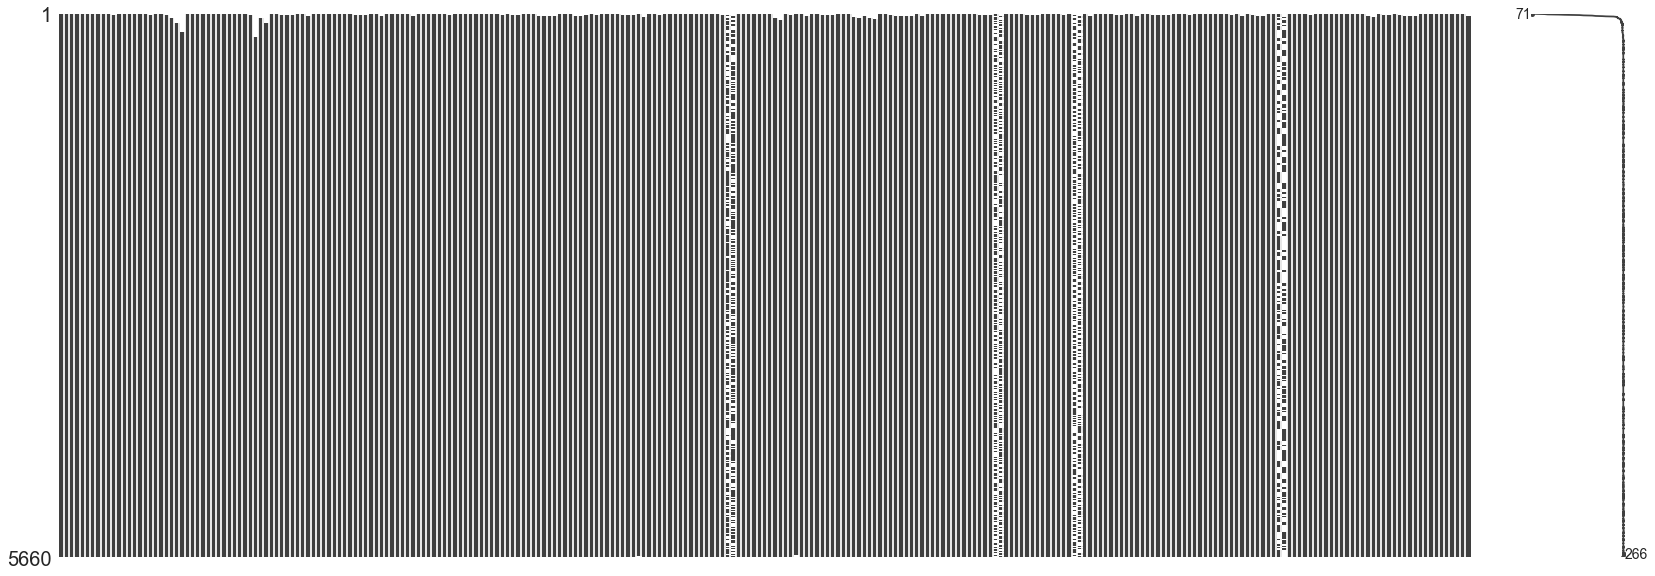

In [24]:
msno.matrix(df)

In [25]:
# copy dataframe
tech_data = df.copy()

# drop unwanted columns
tech_data.drop(['HILOl_13_21', 'HILOs_13_21', 'PSARl_0.02_0.2', 'PSARs_0.02_0.2', 'PSARaf_0.02_0.2', 'QQEl_14_5_4.236', 'QQEs_14_5_4.236', 'SUPERTl_7_3.0', 'SUPERTs_7_3.0'], axis=1, inplace=True)
tech_data = tech_data[200:]



#data.to_excel('Project_TechnicalData.xlsx')

# check last 5 rows
#data.tail()

In [26]:
# check for missing values
tech_data.isna().sum()

Open                            0
High                            0
Low                             0
Close                           0
Adj Close                       0
Volume                          0
Daily_Return                    0
Return_1d                       0
Return_2d                       0
Return_5d                       0
Ret_1M                          0
O-C                             0
H-L                             0
Momentum_1d                     0
Momentum_2d                     0
Momentum_5d                     0
Momentum_10d                    0
Momentum_21d                    0
SMA_5d                          0
SMA_10d                         0
SMA_21d                         0
SMA_50d                         0
SMA_100d                        0
SMA_200d                        0
EMA                             0
EMA_5d                          0
EMA_10d                         0
EMA_21d                         0
EMA_50d                         0
EMA_100d      

In [27]:
df1 = pd.read_excel('IBM_FundamentalFeatures.xlsx', sheet_name='IBM')
df2 = pd.read_excel('IBM_Sentiment_Data_Clean2.xlsx', sheet_name='Sheet1')
df3 = tech_data.copy()
df3.reset_index(drop=False, inplace=True)
df3.head()


,Date,Open,High,Low,Close,Adj Close,Volume,Daily_Return,Return_1d,Return_2d,Return_5d,Ret_1M,O-C,H-L,Momentum_1d,...,TTM_TRND_6,UI_14,UO_7_14_28,VAR_30,VHF_28,VIDYA_14,VTXP_14,VTXM_14,VWAP_D,VWMA_10,WCP,WILLR_14,WMA_10,ZL_EMA_10,ZS_30
0,2000-10-16,106.596558,108.150093,103.788239,106.238052,63.091644,8065078,0.018734,0.055979,-0.082557,0.016565,-0.103559,0.358505,4.361855,1.170979,...,-1,9.602017,48.378388,51.459321,0.368061,113.434605,0.840643,1.057749,106.058795,106.690190,106.103609,-53.454522,106.442291,103.441396,-1.186946
1,2000-10-17,107.014816,108.867111,103.788239,108.030594,64.156197,9291095,0.016732,0.018734,0.055979,-0.026311,-0.100426,-1.015778,5.078873,1.064552,...,1,9.371116,49.359603,48.747335,0.321157,113.365654,0.875000,1.030523,106.895315,106.991869,107.179134,-40.151501,106.577003,104.449618,-0.879763
2,2000-10-18,92.495216,94.765778,86.281075,91.240440,54.184990,31147579,-0.168917,0.016732,0.018734,-0.025346,-0.267841,1.254776,8.484703,-9.971207,...,-1,10.345933,41.282533,60.972602,0.336595,112.494118,0.775328,1.019666,90.762431,101.825970,90.881933,-82.340433,103.616592,100.711690,-2.789958
3,2000-10-19,93.690247,94.168259,88.611374,92.196465,54.752769,18793377,0.010424,-0.168917,0.016732,-0.082557,-0.231019,1.493782,5.556885,0.567780,...,-1,10.992577,43.079565,67.266245,0.351259,111.824638,0.842548,1.007212,91.658699,99.905572,91.793140,-78.936173,101.159178,96.968961,-2.396148
4,2000-10-20,90.941681,92.017204,90.045410,90.583176,53.794697,9800183,-0.017653,0.010424,-0.168917,0.055979,-0.268031,0.358505,1.971794,-0.958073,...,-1,12.007297,40.607026,76.662147,0.354167,110.770067,0.824307,1.055416,90.881930,98.523602,90.807241,-84.549360,98.699592,92.961568,-2.302290


In [28]:
df1['Date'] = pd.to_datetime(df1['Date'], errors='coerce')
df2['Date'] = pd.to_datetime(df2['Date'], errors='coerce')
df3['Date'] = pd.to_datetime(df3['Date'], errors='coerce')


df1['Date'] = df1['Date'].dt.date
df2['Date'] = df2['Date'].dt.date
df3['Date'] = df3['Date'].dt.date

df1['Date'] = pd.to_datetime(df1['Date'], errors='coerce')
df2['Date'] = pd.to_datetime(df2['Date'], errors='coerce')
df3['Date'] = pd.to_datetime(df3['Date'], errors='coerce')



df1 = df1.drop_duplicates(subset='Date')
df2 = df2.drop_duplicates(subset='Date')
df3 = df3.drop_duplicates(subset='Date')


df1.set_index(['Date'], inplace=True)
df2.set_index(['Date'], inplace=True)
df3.set_index(['Date'], inplace=True)

In [29]:
final_df = pd.concat([df1,df2,df3], axis=1)
final_df.head(10)

,Price to Book Ratio,Price/EBITDA,Price Earnings Ratio (P/E),Dividend Indicated Yield - Net,Price to Sales Ratio,Enterprise Value/EBITDA,Current Market Cap,Enterprise Value,Price/Cash Flow,Current Price to Free Cash Flow,Current Shares Outstanding,ESS_D_AVG_SENT,ESS_AVG_SENT_7,ESS_AVG_SENT_30,ESS_AVG_SENT_90,...,TTM_TRND_6,UI_14,UO_7_14_28,VAR_30,VHF_28,VIDYA_14,VTXP_14,VTXM_14,VWAP_D,VWMA_10,WCP,WILLR_14,WMA_10,ZL_EMA_10,ZS_30
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
NaT,5.9165,8.7579,14.3711,5.1907,1.7847,12.2795,114363.2016,160247.2016,11.6293,13.9388,899.435,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1999-12-31,9.0724,10.0652,27.7731,0.4658,2.1277,11.6272,192472.2948,215242.2948,18.4010,44.8622,1784.216,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.25000,0.25000,0.25000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-03,9.7557,10.8233,29.8650,0.4332,2.2879,12.4103,206969.0493,229739.0493,19.7869,48.2412,1784.216,0.46375,0.35688,0.35688,0.35688,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-04,9.4245,10.4559,28.8512,0.4484,2.2103,12.0308,199943.6990,222713.6990,19.1153,46.6037,1784.216,0.17667,0.29681,0.29681,0.29681,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-05,9.7557,10.8233,29.8650,0.4332,2.2879,12.4103,206969.0493,229739.0493,19.7869,48.2412,1784.216,0.51111,0.35038,0.35038,0.35038,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-06,9.5875,10.6367,29.3501,0.4408,2.2485,12.2175,203400.6174,226170.6174,19.4458,47.4094,1784.216,0.49000,0.37831,0.37831,0.37831,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-07,9.5454,10.5900,29.2213,0.4428,2.2386,12.1693,202508.5095,225278.5095,19.3605,47.2015,1784.216,0.26778,0.35988,0.35988,0.35988,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.36000,0.37822,0.35990,0.35990,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [30]:
final_df = final_df.reindex(df3.index)
final_df.head()


,Price to Book Ratio,Price/EBITDA,Price Earnings Ratio (P/E),Dividend Indicated Yield - Net,Price to Sales Ratio,Enterprise Value/EBITDA,Current Market Cap,Enterprise Value,Price/Cash Flow,Current Price to Free Cash Flow,Current Shares Outstanding,ESS_D_AVG_SENT,ESS_AVG_SENT_7,ESS_AVG_SENT_30,ESS_AVG_SENT_90,...,TTM_TRND_6,UI_14,UO_7_14_28,VAR_30,VHF_28,VIDYA_14,VTXP_14,VTXM_14,VWAP_D,VWMA_10,WCP,WILLR_14,WMA_10,ZL_EMA_10,ZS_30
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2000-10-16,9.6484,12.2580,25.9517,0.4899,2.1657,14.4661,195658.3111,222243.3111,23.8781,66.8688,1760.705,0.53000,0.39141,0.37938,0.40666,...,-1.0,9.602017,48.378388,51.459321,0.368061,113.434605,0.840643,1.057749,106.058795,106.690190,106.103609,-53.454522,106.442291,103.441396,-1.186946
2000-10-17,9.8112,12.4648,26.3896,0.4818,2.2022,14.6810,198959.6324,225544.6324,24.2810,67.9971,1760.705,0.66800,0.44186,0.39141,0.41016,...,1.0,9.371116,49.359603,48.747335,0.321157,113.365654,0.875000,1.030523,106.895315,106.991869,107.179134,-40.151501,106.577003,104.449618,-0.879763
2000-10-18,8.2863,10.5275,22.2881,0.5704,1.8599,12.6682,168037.2559,194622.2559,20.5073,57.4290,1760.705,0.23708,0.41343,0.38152,0.40656,...,-1.0,10.345933,41.282533,60.972602,0.336595,112.494118,0.775328,1.019666,90.762431,101.825970,90.881933,-82.340433,103.616592,100.711690,-2.789958
2000-10-19,8.3732,10.6378,22.5217,0.5645,1.8794,12.7829,169797.9607,196382.9607,20.7221,58.0307,1760.705,-0.20438,0.34312,0.35376,0.39819,...,-1.0,10.992577,43.079565,67.266245,0.351259,111.824638,0.842548,1.007212,91.658699,99.905572,91.793140,-78.936173,101.159178,96.968961,-2.396148
2000-10-20,8.2267,10.4517,22.1276,0.5746,1.8465,12.5895,166826.7715,193411.7715,20.3595,57.0153,1760.705,0.44600,0.36612,0.35618,0.40557,...,-1.0,12.007297,40.607026,76.662147,0.354167,110.770067,0.824307,1.055416,90.881930,98.523602,90.807241,-84.549360,98.699592,92.961568,-2.302290


In [31]:
# copy dataframe
data = final_df.copy()

# define target (label)
data['predict'] = np.where(data['Adj Close'].pct_change(-5) > 0, 1, 0)

# backfill columns to address missing values
data = data.bfill(axis=1)
data = data[:-5] # to take care of 5day ahead prediction

data.to_excel('Project_ConsolidatedIBMFeatureData2.xlsx')
# check last 5 rows
data.tail()

,Price to Book Ratio,Price/EBITDA,Price Earnings Ratio (P/E),Dividend Indicated Yield - Net,Price to Sales Ratio,Enterprise Value/EBITDA,Current Market Cap,Enterprise Value,Price/Cash Flow,Current Price to Free Cash Flow,Current Shares Outstanding,ESS_D_AVG_SENT,ESS_AVG_SENT_7,ESS_AVG_SENT_30,ESS_AVG_SENT_90,...,UI_14,UO_7_14_28,VAR_30,VHF_28,VIDYA_14,VTXP_14,VTXM_14,VWAP_D,VWMA_10,WCP,WILLR_14,WMA_10,ZL_EMA_10,ZS_30,predict
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2022-06-15,6.4712,9.4002,17.5427,4.8154,1.9609,13.0237,123276.6056,170401.6056,11.0522,13.2553,899.435,0.34364,0.32043,0.25263,0.24955,...,2.782102,44.002506,15.124838,0.264706,134.404709,1.037933,0.872972,137.029999,138.592081,137.037498,-69.917934,137.826728,135.778447,0.273073,0.0
2022-06-16,6.4056,9.3049,17.3647,4.8647,1.9410,12.9281,122026.3905,169151.3905,10.9401,13.1209,899.435,0.50800,0.38065,0.27421,0.25462,...,3.078513,40.918472,15.057329,0.266469,134.416169,0.948963,0.978777,135.433334,138.105988,135.492500,-82.588847,137.223819,135.664183,-0.069667,0.0
2022-06-17,6.3749,9.2603,17.2816,4.8882,1.9317,12.8834,121441.7576,168566.7576,10.8877,13.0580,899.435,0.32167,0.37787,0.27479,0.25660,...,3.411574,43.154749,15.085590,0.279829,134.437252,0.854870,1.023495,134.950002,137.097804,134.967503,-81.734006,136.584183,135.530696,-0.229229,0.0
2022-06-21,6.5085,9.4544,17.6438,4.7878,1.9722,13.0780,123987.1596,171112.1596,11.1159,13.3317,899.435,0.39429,0.26544,0.25211,0.26492,...,3.537976,51.153593,15.108516,0.293998,134.461432,0.919409,0.967328,137.416667,136.629492,137.525002,-57.912421,136.571093,136.339663,0.497476,0.0
2022-06-22,6.4722,9.4016,17.5452,4.8147,1.9612,13.0250,123294.5944,170419.5944,11.0538,13.2572,899.435,0.10200,0.23092,0.25154,0.26295,...,3.700581,52.295065,15.072042,0.299190,134.505052,0.881743,0.990607,137.096664,136.327777,137.092499,-64.393944,136.509457,136.477907,0.277072,0.0


In [32]:
# check for missing values
data.isna().sum()

Price to Book Ratio                0
Price/EBITDA                       0
Price Earnings Ratio (P/E)         0
Dividend Indicated Yield - Net     0
Price to Sales Ratio               0
Enterprise Value/EBITDA            0
Current Market Cap                 0
Enterprise Value                   0
Price/Cash Flow                    0
Current Price to Free Cash Flow    0
Current Shares Outstanding         0
ESS_D_AVG_SENT                     0
ESS_AVG_SENT_7                     0
ESS_AVG_SENT_30                    0
ESS_AVG_SENT_90                    0
ESS_NEWS_COUNT                     0
Open                               0
High                               0
Low                                0
Close                              0
Adj Close                          0
Volume                             0
Daily_Return                       0
Return_1d                          0
Return_2d                          0
Return_5d                          0
Ret_1M                             0
O

In [33]:
# class frequency
c = data['predict'].value_counts()
c

0.0    2879
1.0    2576
Name: predict, dtype: int64

In [34]:
# class weight function
def cwts(dfs):
    c0, c1 = np.bincount(dfs['predict'])
    w0=(1/c0)*(len(df))/2 
    w1=(1/c1)*(len(df))/2 
    return {0: w0, 1: w1}

In [35]:
# check class weights
class_weight = cwts(data)
class_weight

{0: 0.9829802014588398, 1: 1.0986024844720497}

In [36]:
# With the calculated weights, both classes gain equal weight
class_weight[0] * c[0], class_weight[1] * c[1]

(2830.0, 2830.0)

In [37]:
X = data.drop('predict', axis=1)
feature_names = X.columns
X.tail()

,Price to Book Ratio,Price/EBITDA,Price Earnings Ratio (P/E),Dividend Indicated Yield - Net,Price to Sales Ratio,Enterprise Value/EBITDA,Current Market Cap,Enterprise Value,Price/Cash Flow,Current Price to Free Cash Flow,Current Shares Outstanding,ESS_D_AVG_SENT,ESS_AVG_SENT_7,ESS_AVG_SENT_30,ESS_AVG_SENT_90,...,TTM_TRND_6,UI_14,UO_7_14_28,VAR_30,VHF_28,VIDYA_14,VTXP_14,VTXM_14,VWAP_D,VWMA_10,WCP,WILLR_14,WMA_10,ZL_EMA_10,ZS_30
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2022-06-15,6.4712,9.4002,17.5427,4.8154,1.9609,13.0237,123276.6056,170401.6056,11.0522,13.2553,899.435,0.34364,0.32043,0.25263,0.24955,...,-1.0,2.782102,44.002506,15.124838,0.264706,134.404709,1.037933,0.872972,137.029999,138.592081,137.037498,-69.917934,137.826728,135.778447,0.273073
2022-06-16,6.4056,9.3049,17.3647,4.8647,1.9410,12.9281,122026.3905,169151.3905,10.9401,13.1209,899.435,0.50800,0.38065,0.27421,0.25462,...,-1.0,3.078513,40.918472,15.057329,0.266469,134.416169,0.948963,0.978777,135.433334,138.105988,135.492500,-82.588847,137.223819,135.664183,-0.069667
2022-06-17,6.3749,9.2603,17.2816,4.8882,1.9317,12.8834,121441.7576,168566.7576,10.8877,13.0580,899.435,0.32167,0.37787,0.27479,0.25660,...,-1.0,3.411574,43.154749,15.085590,0.279829,134.437252,0.854870,1.023495,134.950002,137.097804,134.967503,-81.734006,136.584183,135.530696,-0.229229
2022-06-21,6.5085,9.4544,17.6438,4.7878,1.9722,13.0780,123987.1596,171112.1596,11.1159,13.3317,899.435,0.39429,0.26544,0.25211,0.26492,...,1.0,3.537976,51.153593,15.108516,0.293998,134.461432,0.919409,0.967328,137.416667,136.629492,137.525002,-57.912421,136.571093,136.339663,0.497476
2022-06-22,6.4722,9.4016,17.5452,4.8147,1.9612,13.0250,123294.5944,170419.5944,11.0538,13.2572,899.435,0.10200,0.23092,0.25154,0.26295,...,1.0,3.700581,52.295065,15.072042,0.299190,134.505052,0.881743,0.990607,137.096664,136.327777,137.092499,-64.393944,136.509457,136.477907,0.277072


In [38]:
y = data['predict'].values
# pandas-ta converts all dtype to objects
y = y.astype(int) 
y

array([1, 1, 1, ..., 0, 0, 0])

In [39]:
# Always keep shuffle = False for financial time series
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

X2_train = X_train

# convert to array
X_train, X_test, y_train, y_test = np.array(X_train), np.array(X_test), np.array(y_train), np.array(y_test) 


# Output the train and test data size
print(f"Train and Test Size {len(X_train)}, {len(X_test)}")

Train and Test Size 4364, 1091


In [40]:
# define random forest classifier
forest = RandomForestClassifier(n_jobs=-1, 
                                class_weight=cwts(data), 
                                random_state=42, 
                                max_depth=5)

# train the model
forest.fit(X_train, y_train)

RandomForestClassifier(class_weight={0: 0.9829802014588398,
                                     1: 1.0986024844720497},
                       max_depth=5, n_jobs=-1, random_state=42)

In [41]:
# print scores
print("Accuracy Score \t\t", accuracy_score(y_test, forest.predict(X_test)))

Accuracy Score 		 0.7442713107241063


In [42]:
# define Boruta feature selection method
feat_selector = BorutaPy(forest, n_estimators='auto', verbose=2, random_state=0)

# find all relevant features
# takes input in array format not as dataframe
feat_selector.fit(X_train, y_train) 

# check selected features
print(feat_selector.support_)

# check ranking of features
print(feat_selector.ranking_)

# call transform() on X to filter it down to selected features
X_filtered = feat_selector.transform(X_train)

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	276
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	276
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	276
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	276
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	276
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	276
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	276
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	35
Tentative: 	126
Rejected: 	115
Iteration: 	9 / 100
Confirmed: 	35
Tentative: 	126
Rejected: 	115
Iteration: 	10 / 100
Confirmed: 	35
Tentative: 	126
Rejected: 	115
Iteration: 	11 / 100
Confirmed: 	35
Tentative: 	126
Rejected: 	115
Iteration: 	12 / 100
Confirmed: 	42
Tentative: 	105
Rejected: 	129
Iteration: 	13 / 100
Confirmed: 	42
Tentative: 	105
Rejected: 	129
Iteration: 	14 / 100
Confirmed: 	42
Tentative: 	105
Rejected: 	129
Iteration: 	15 / 100
Confirmed: 	42
Tentative: 	105
Rejected: 	129
Iteration: 	16 / 100
Conf

In [43]:
# zip my names, ranks, and decisions in a single iterable
feature_ranks = list(zip(feature_names, 
                         feat_selector.ranking_, 
                         feat_selector.support_))

# iterate through and print out the results
for feat in feature_ranks:
    print(f'Feature: {feat[0]:<30} Rank: {feat[1]:<5} Keep: {feat[2]}')

Feature: Price to Book Ratio            Rank: 1     Keep: True
Feature: Price/EBITDA                   Rank: 1     Keep: True
Feature: Price Earnings Ratio (P/E)     Rank: 1     Keep: True
Feature: Dividend Indicated Yield - Net Rank: 1     Keep: True
Feature: Price to Sales Ratio           Rank: 1     Keep: True
Feature: Enterprise Value/EBITDA        Rank: 1     Keep: True
Feature: Current Market Cap             Rank: 1     Keep: True
Feature: Enterprise Value               Rank: 1     Keep: True
Feature: Price/Cash Flow                Rank: 1     Keep: True
Feature: Current Price to Free Cash Flow Rank: 1     Keep: True
Feature: Current Shares Outstanding     Rank: 2     Keep: False
Feature: ESS_D_AVG_SENT                 Rank: 108   Keep: False
Feature: ESS_AVG_SENT_7                 Rank: 1     Keep: True
Feature: ESS_AVG_SENT_30                Rank: 1     Keep: True
Feature: ESS_AVG_SENT_90                Rank: 1     Keep: True
Feature: ESS_NEWS_COUNT                 Rank: 120   

In [44]:
selected_rf_features = pd.DataFrame({'Feature':feature_names,
                                     'Ranking':feat_selector.ranking_})

# selected_rf_features#.sort_values(by='Ranking') 

selected_rf_features[selected_rf_features['Ranking']==1]

,Feature,Ranking
0,Price to Book Ratio,1
1,Price/EBITDA,1
2,Price Earnings Ratio (P/E),1
3,Dividend Indicated Yield - Net,1
4,Price to Sales Ratio,1
5,Enterprise Value/EBITDA,1
6,Current Market Cap,1
7,Enterprise Value,1
8,Price/Cash Flow,1
9,Current Price to Free Cash Flow,1


In [45]:
# check the shape 
X_filtered.shape

(4364, 98)

In [46]:
# fit with selected features
forest.fit(X_filtered, y_train)

RandomForestClassifier(class_weight={0: 0.9829802014588398,
                                     1: 1.0986024844720497},
                       max_depth=5, n_estimators=331, n_jobs=-1,
                       random_state=RandomState(MT19937) at 0x1B73D103D40)

In [47]:
#to predict
# first appl feature selector transform to make sure same features are selected
X_test_filtered = feat_selector.transform(X_test)
X_test_filtered

array([[  7.6695    ,   8.544     ,  11.0229    , ..., 150.54204914,
          0.80340201, -50.1136746 ],
       [  7.7867    ,   8.6745    ,  11.1913    , ..., 150.51507138,
          0.86979482, -21.13468113],
       [  7.9399    ,   8.8452    ,  11.4115    , ..., 150.54557805,
          1.0595991 ,  -2.07180326],
       ...,
       [  6.3749    ,   9.2603    ,  17.2816    , ..., 134.43725204,
          0.85486967, -81.73400619],
       [  6.5085    ,   9.4544    ,  17.6438    , ..., 134.46143234,
          0.91940903, -57.91242115],
       [  6.4722    ,   9.4016    ,  17.5452    , ..., 134.50505176,
          0.88174321, -64.39394426]])

In [48]:
# check the shape
X_test_filtered.shape

(1091, 98)

In [49]:
# predict labels with unseen dataset
prediction = forest.predict(X_test_filtered)

In [50]:
# print scores
print("Accuracy Score \t\t", accuracy_score(y_test, prediction))

Accuracy Score 		 0.7580201649862511


In [51]:
# Classification Report
print(classification_report(y_test, prediction))

              precision    recall  f1-score   support

           0       0.79      0.77      0.78       601
           1       0.72      0.75      0.73       490

    accuracy                           0.76      1091
   macro avg       0.76      0.76      0.76      1091
weighted avg       0.76      0.76      0.76      1091



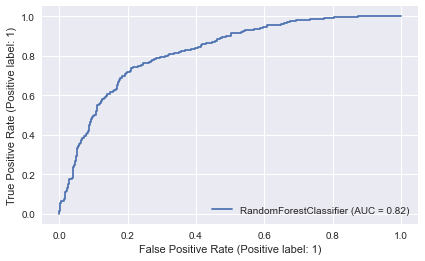

In [52]:
# plot roc
plot_roc_curve(forest, X_test_filtered, y_test);

In [53]:
X_train.shape

(4364, 276)

In [54]:
X_filtered.shape

(4364, 98)

In [55]:
#Create new data frame with Boruta modified features

BorIBMdata = data[['Open', 'High', 'Close', 'Adj Close']]

for i in selected_rf_features[selected_rf_features['Ranking']==1]['Feature']:

    BorIBMdata[str(i)] = data[str(i)]


In [56]:
BorIBMdata.shape

(5455, 102)

# SOM

In [57]:
BorIBMdata = BorIBMdata.dropna()

In [58]:
BorIBMdata.shape

(5455, 102)

In [59]:
Z=BorIBMdata.T

In [60]:
# Transform Feature Matrix
scaler = MinMaxScaler()
Z = scaler.fit_transform(Z)
Z.shape

(102, 5455)

In [61]:
from minisom import MiniSom    
from matplotlib.gridspec import GridSpec

som = MiniSom(18, 18, Z.shape[1], learning_rate=0.5, sigma=1, random_seed=42)

# Initialize with randon weights
som.random_weights_init(Z)

# Trains SOM with 10000 iterations
som.train_batch(Z,10000, verbose=True)



 [ 10000 / 10000 ] 100% - 0:00:00 left 
 quantization error: 4.631778664740566e-07


Text(0.5, 1.0, 'Self Organizing Maps')

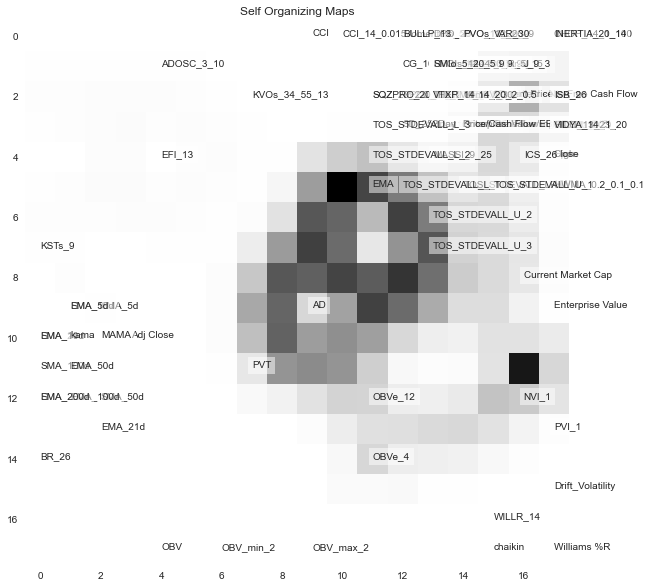

In [62]:
# Plot SOM
plt.figure(figsize=(20, 10))
for ix in range(len(Z)):
    winner = som.winner(Z[ix])
    plt.text(winner[0], winner[1], BorIBMdata.columns[ix] , bbox=dict(facecolor='white', alpha=0.5, lw=0)) 
plt.imshow(som.distance_map())
plt.grid(False)
plt.title('Self Organizing Maps')

In [63]:
# List the corresponding features
feat_dict = dict()
for ix in range(len(Z)):
    winner = som.winner(Z[ix])
    
    if (winner[0], winner[1]) in feat_dict:
        feat_dict[(winner[0], winner[1])].append(BorIBMdata.columns[ix])
    else:
        feat_dict[(winner[0], winner[1])] = [BorIBMdata.columns[ix]]
    
#     print(winner[0], winner[1], BorIBMdata.columns[ix])

In [64]:
feat_dict

{(17, 4): ['Open', 'High', 'Close'],
 (3, 10): ['Adj Close'],
 (13, 3): ['Price to Book Ratio'],
 (14, 3): ['Price/EBITDA', 'Enterprise Value/EBITDA', 'Price/Cash Flow'],
 (15, 3): ['Price Earnings Ratio (P/E)'],
 (13, 2): ['Dividend Indicated Yield - Net',
  'Price to Sales Ratio',
  'THERMOma_20_2_0.5',
  'VTXP_14'],
 (16, 8): ['Current Market Cap'],
 (17, 9): ['Enterprise Value'],
 (15, 2): ['Current Price to Free Cash Flow'],
 (13, 1): ['ESS_AVG_SENT_7',
  'ESS_AVG_SENT_30',
  'ESS_AVG_SENT_90',
  'Ultimate_Oscillator',
  'DMP_14',
  'EBSW_40_10',
  'MACDh_12_26_9',
  'PGO_14',
  'PPOh_12_26_9',
  'RVGI_14_4',
  'RVGIs_14_4',
  'SMIo_5_20_5'],
 (12, 0): ['Momentum_5d', 'BULLP_13'],
 (2, 9): ['SMA_5d'],
 (1, 9): ['SMA_10d', 'EMA_5d'],
 (0, 10): ['SMA_21d', 'EMA_10d'],
 (2, 12): ['SMA_50d'],
 (0, 11): ['SMA_100d'],
 (0, 12): ['SMA_200d', 'EMA_200d'],
 (11, 5): ['EMA'],
 (2, 13): ['EMA_21d'],
 (1, 11): ['EMA_50d'],
 (1, 12): ['EMA_100d'],
 (12, 3): ['SD_252Day'],
 (14, 1): ['SD_50Day'

In [65]:
col_drop = ['SMA_10d',
'SQZPRO_20_2.0_20_2_1.5_1',
'PVOs_12_26_9',
'HWU', 'HWMA_0.2_0.1_0.1',
'ISB_26',
'CHOP_14_1_100',
'CKSPl_10_3_20', 'HILO_13_21', 'VIDYA_14',
'ABER_ATR_5_15', 'ATRr_14', 'MAD_30',
'Open',
'High',
'Enterprise Value/EBITDA', 'Price/Cash Flow',
'Dividend Indicated Yield - Net',
'THERMOma_20_2_0.5',
'VTXP_14',
'ESS_AVG_SENT_7',
'ESS_AVG_SENT_30',
'ESS_AVG_SENT_90',
'DMP_14',
'EBSW_40_10',
'MACDh_12_26_9',
'PGO_14',
'PPOh_12_26_9',
'RVGI_14_4',
'RVGIs_14_4',
'SMIo_5_20_5',
'BULLP_13']

In [66]:
SOMIBMdata = BorIBMdata.copy()

In [67]:
SOMIBMdata.drop(col_drop,inplace=True,axis=1)

In [68]:
SOMIBMdata

,Close,Adj Close,Price to Book Ratio,Price/EBITDA,Price Earnings Ratio (P/E),Price to Sales Ratio,Current Market Cap,Enterprise Value,Current Price to Free Cash Flow,Momentum_5d,SMA_5d,SMA_21d,SMA_50d,SMA_100d,SMA_200d,...,PVI_1,PVO_12_26_9,PVT,SQZ_20_2.0_20_1.5,STDEV_30,TOS_STDEVALL_LR,TOS_STDEVALL_L_1,TOS_STDEVALL_U_1,TOS_STDEVALL_L_2,TOS_STDEVALL_U_2,TOS_STDEVALL_L_3,TOS_STDEVALL_U_3,UI_14,VAR_30,WILLR_14
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2000-10-16,106.238052,63.091644,9.6484,12.2580,25.9517,2.1657,195658.3111,222243.3111,66.8688,-3.867821,62.474207,66.139943,69.105698,66.121010,64.982691,...,987.403798,9.874258,1.996427e+08,-8.385118,7.173515,91.321772,56.526574,126.116970,21.731376,160.912167,-13.063822,195.707365,9.602017,51.459321,-53.454522
2000-10-17,108.030594,64.156197,9.8112,12.4648,26.3896,2.2022,198959.6324,225544.6324,67.9971,-1.064499,62.261307,65.862825,69.069561,66.158589,64.975285,...,989.091085,10.280103,2.153195e+08,-7.757726,6.981929,91.334206,56.539008,126.129404,21.743810,160.924602,-13.051388,195.719800,9.371116,48.747335,-40.151501
2000-10-18,91.240440,54.184990,8.2863,10.5275,22.2881,1.8599,168037.2559,194622.2559,57.4290,-9.403416,60.380624,65.065265,68.803426,66.093976,64.929162,...,973.549050,27.496709,-2.687773e+08,-9.888860,7.808496,91.346640,56.551442,126.141838,21.756244,160.937036,-13.038954,195.732234,10.345933,60.972602,-82.340433
2000-10-19,92.196465,54.752769,8.3732,10.6378,22.5217,1.8794,169797.9607,196382.9607,58.0307,-3.796852,59.621253,64.299811,68.550066,66.012356,64.874739,...,973.549050,29.281146,-2.490855e+08,-10.386789,8.201600,91.359074,56.563876,126.154272,21.768678,160.949470,-13.026520,195.744668,10.992577,67.266245,-78.936173
2000-10-20,90.583176,53.794697,8.2267,10.4517,22.1276,1.8465,166826.7715,193411.7715,57.0153,-8.125969,57.996059,63.576601,68.266189,65.941713,64.821184,...,973.549050,24.689384,-2.662342e+08,-10.964386,8.755692,91.371508,56.576310,126.166706,21.781112,160.961904,-13.014086,195.757102,12.007297,76.662147,-84.549360
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-06-15,137.059998,137.059998,6.4712,9.4002,17.5427,1.9609,123276.6056,170401.6056,13.2553,-3.770004,136.408002,136.814285,133.572815,130.488246,127.294145,...,872.479711,-3.630479,-1.219663e+09,3.145002,3.889066,159.087238,124.292040,193.882436,89.496842,228.677634,54.701644,263.472832,2.782102,15.124838,-69.917934
2022-06-16,135.669998,135.669998,6.4056,9.3049,17.3647,1.9410,122026.3905,169151.3905,13.1209,-2.290009,135.950000,136.685714,133.739310,130.587334,127.326207,...,871.465557,-1.990919,-1.225126e+09,0.558334,3.880377,159.099672,124.304474,193.894870,89.509276,228.690068,54.714078,263.485266,3.078513,15.057329,-82.588847
2022-06-17,135.020004,135.020004,6.3749,9.2603,17.2816,1.9317,121441.7576,168566.7576,13.0580,-1.169998,135.716000,136.784762,133.882926,130.608850,127.359808,...,870.986458,10.557017,-1.231339e+09,-1.308332,3.884017,159.112106,124.316908,193.907304,89.521710,228.702502,54.726512,263.497700,3.411574,15.085590,-81.734006


In [69]:
SOMIBMdata.shape

(5455, 70)

# K-Means

In [70]:
from sklearn.cluster import KMeans

In [71]:
kmeans = KMeans(n_clusters=35)
kmeans.fit(SOMIBMdata)

KMeans(n_clusters=35)

In [72]:
# X_filtered_kmeans = kmeans.transform(X_filtered)

# Calculate the distance of each data point from each cluster center.
# For example, you can find for each sample its distance to each of k cluster center, 
# and so create k new features
SOM_Kmeans_IBMdata = np.column_stack([np.sum((SOMIBMdata - center)**2, axis=1)**0.5 for center in kmeans.cluster_centers_])

In [73]:
SOM_Kmeans_IBMdata.shape

(5455, 35)

In [74]:
SOM_Kmeans_IBMdata

array([[2.50761707e+08, 1.18795207e+09, 6.48511324e+08, ...,
        6.77125926e+08, 8.86841561e+08, 1.75424706e+08],
       [2.59903484e+08, 1.19368473e+09, 6.35737892e+08, ...,
        6.97087142e+08, 8.93664597e+08, 1.62688785e+08],
       [2.88652626e+08, 8.31556283e+08, 7.64606541e+08, ...,
        3.69023080e+08, 5.54102157e+08, 5.10785217e+08],
       ...,
       [1.28453948e+09, 4.70531249e+08, 1.38232367e+09, ...,
        1.15279879e+09, 6.82549116e+08, 1.49046274e+09],
       [1.27682495e+09, 4.64191674e+08, 1.37429007e+09, ...,
        1.14651948e+09, 6.73826847e+08, 1.48268038e+09],
       [1.27846729e+09, 4.67672381e+08, 1.37693984e+09, ...,
        1.14681809e+09, 6.75930917e+08, 1.48456240e+09]])

# New Thought ...correlation coeff

- check correlation coeff among all features and if its strongly correlated i.e > 0.98 or 0.95 then delete that that columns

In [76]:
corr_matrix = BorIBMdata.corr()

In [77]:
corr_matrix

,Open,High,Close,Adj Close,Price to Book Ratio,Price/EBITDA,Price Earnings Ratio (P/E),Dividend Indicated Yield - Net,Price to Sales Ratio,Enterprise Value/EBITDA,Current Market Cap,Enterprise Value,Price/Cash Flow,Current Price to Free Cash Flow,ESS_AVG_SENT_7,...,SQZPRO_20_2.0_20_2_1.5_1,STDEV_30,THERMOma_20_2_0.5,TOS_STDEVALL_LR,TOS_STDEVALL_L_1,TOS_STDEVALL_U_1,TOS_STDEVALL_L_2,TOS_STDEVALL_U_2,TOS_STDEVALL_L_3,TOS_STDEVALL_U_3,UI_14,VAR_30,VIDYA_14,VTXP_14,WILLR_14
Open,1.000000,0.999602,0.999205,0.917399,0.764453,-0.183878,-0.460805,0.336810,0.662859,-0.191132,0.621687,0.744280,0.104913,-0.125573,-0.080772,...,0.092891,0.142424,0.228015,0.592508,0.592508,0.592508,0.592508,0.592508,0.592508,0.592508,-0.257530,0.029343,0.990714,0.070924,0.053762
High,0.999602,1.000000,0.999613,0.917688,0.766200,-0.184746,-0.460392,0.337082,0.663690,-0.190888,0.622723,0.746508,0.108006,-0.121596,-0.081965,...,0.091068,0.148992,0.237648,0.592185,0.592185,0.592185,0.592185,0.592185,0.592185,0.592185,-0.251703,0.035795,0.990957,0.070957,0.059719
Close,0.999205,0.999613,1.000000,0.917604,0.765797,-0.182618,-0.459755,0.335488,0.664735,-0.190598,0.623666,0.746011,0.105984,-0.125131,-0.080137,...,0.095428,0.142641,0.227720,0.591828,0.591828,0.591828,0.591828,0.591828,0.591828,0.591828,-0.258915,0.030053,0.989874,0.076553,0.070063
Adj Close,0.917399,0.917688,0.917604,1.000000,0.575681,-0.271390,-0.496303,0.655493,0.516335,-0.092967,0.295893,0.512296,-0.103470,-0.265678,-0.149396,...,0.074464,0.163065,0.263941,0.844694,0.844694,0.844694,0.844694,0.844694,0.844694,0.844694,-0.206215,0.059777,0.912043,0.050543,0.046790
Price to Book Ratio,0.764453,0.766200,0.765797,0.575681,1.000000,-0.077108,-0.327756,0.002716,0.614550,-0.214622,0.672311,0.699125,0.328433,0.161344,-0.023575,...,0.091209,0.154229,0.262366,0.201114,0.201114,0.201114,0.201114,0.201114,0.201114,0.201114,-0.172290,0.036327,0.756894,0.076436,0.069964
Price/EBITDA,-0.183878,-0.184746,-0.182618,-0.271390,-0.077108,1.000000,0.874128,-0.529008,0.544560,0.862938,0.316084,0.277925,0.602028,0.529618,0.118230,...,0.142502,-0.100211,-0.157363,-0.524086,-0.524086,-0.524086,-0.524086,-0.524086,-0.524086,-0.524086,-0.119829,-0.121916,-0.217254,0.125992,0.068389
Price Earnings Ratio (P/E),-0.460805,-0.460392,-0.459755,-0.496303,-0.327756,0.874128,1.000000,-0.560972,0.303046,0.806501,0.121335,0.093082,0.528281,0.546158,0.146365,...,0.092738,-0.097061,-0.143450,-0.619944,-0.619944,-0.619944,-0.619944,-0.619944,-0.619944,-0.619944,-0.004014,-0.084556,-0.486292,0.090485,0.047686
Dividend Indicated Yield - Net,0.336810,0.337082,0.335488,0.655493,0.002716,-0.529008,-0.560972,1.000000,-0.160637,-0.113600,-0.488704,-0.231732,-0.555215,-0.479910,-0.220359,...,-0.061766,0.173459,0.245616,0.942327,0.942327,0.942327,0.942327,0.942327,0.942327,0.942327,0.051860,0.155622,0.353471,-0.062796,-0.042342
Price to Sales Ratio,0.662859,0.663690,0.664735,0.516335,0.614550,0.544560,0.303046,-0.160637,1.000000,0.427022,0.790924,0.861316,0.614617,0.392241,0.030850,...,0.179782,0.086756,0.129513,0.046531,0.046531,0.046531,0.046531,0.046531,0.046531,0.046531,-0.268989,-0.028982,0.631915,0.157840,0.120548
Enterprise Value/EBITDA,-0.191132,-0.190888,-0.190598,-0.092967,-0.214622,0.862938,0.806501,-0.113600,0.427022,1.000000,-0.001166,0.128536,0.386798,0.392735,0.017518,...,0.104139,0.004970,0.005068,-0.178787,-0.178787,-0.178787,-0.178787,-0.178787,-0.178787,-0.178787,-0.008246,-0.019721,-0.215273,0.089196,0.030198


In [79]:
# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find features with correlation value greater than 0.98 (i.e. features to be strongly dependent)
to_drop = [column for column in upper.columns if any(upper[column] > 0.98)]

In [80]:
to_drop

['High',
 'Close',
 'SMA_5d',
 'SMA_10d',
 'SMA_21d',
 'SMA_50d',
 'SMA_100d',
 'SMA_200d',
 'EMA_5d',
 'EMA_10d',
 'EMA_21d',
 'EMA_50d',
 'EMA_100d',
 'EMA_200d',
 'kama',
 'MAMA',
 'ACCBL_20',
 'OBV_min_2',
 'OBV_max_2',
 'OBVe_4',
 'OBVe_12',
 'ATRr_14',
 'CKSPl_10_3_20',
 'HILO_13_21',
 'HWM',
 'HWU',
 'HWMA_0.2_0.1_0.1',
 'ISA_9',
 'ISB_26',
 'SQZPRO_20_2.0_20_2_1.5_1',
 'STDEV_30',
 'TOS_STDEVALL_L_1',
 'TOS_STDEVALL_U_1',
 'TOS_STDEVALL_L_2',
 'TOS_STDEVALL_U_2',
 'TOS_STDEVALL_L_3',
 'TOS_STDEVALL_U_3',
 'VIDYA_14']